# MLB Swing Decision Analysis

This notebook demonstrates a complete pipeline for evaluating batter swing decisions using 2022–2024 Statcast data:

1. Load raw data  
2. Perform feature engineering  
3. Build preprocessing pipeline and train/test split  
4. Train an XGBoost regression model  
5. Visualize feature importances  
6. Generate top/bottom 10 batter leaderboard  
7. Analyze decision quality for an individual player  
8. Summarize conclusions and future directions  


In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing and splitting
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# XGBoost model
import xgboost as xgb

# For saving/loading objects
import joblib

## 1. Load Raw Data

We already have `data/raw/statcast_2022_2024.csv` locally.  

In [4]:
# Read in existing Statcast CSV (no new download)
raw_path = '../data/raw/statcast_2022_2024.csv'
df_raw = pd.read_csv(raw_path)

# Inspect shape and first rows
print(f'Loaded {df_raw.shape[0]} rows and {df_raw.shape[1]} columns from raw data.')
df_raw.head()

Loaded 2160560 rows and 113 columns from raw data.


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,ST,2022-10-15,82.8,-0.73,6.28,"Garcia, Luis",677594,677651,field_out,hit_into_play,...,2,7,13.0,2.0,13.0,NaN,3.36,-1.15,-1.15,43.7
1,ST,2022-10-15,82.4,-0.73,6.26,"Garcia, Luis",677594,677651,NaN,swinging_strike,...,2,7,13.0,2.0,13.0,NaN,3.51,-1.36,-1.36,44.0
2,FF,2022-10-15,96.6,-0.68,6.26,"Garcia, Luis",677594,677651,NaN,called_strike,...,2,7,13.0,2.0,13.0,NaN,0.96,0.60,0.60,43.5
3,FF,2022-10-15,97.6,-0.77,6.24,"Garcia, Luis",641487,677651,field_out,hit_into_play,...,2,6,13.0,2.0,13.0,NaN,0.91,0.76,-0.76,41.3
4,FF,2022-10-15,96.9,-0.76,6.23,"Garcia, Luis",641487,677651,NaN,called_strike,...,2,6,13.0,2.0,13.0,NaN,0.75,0.72,-0.72,39.9


## 2. Feature Engineering

In [6]:
# Feature Engineering (in-notebook version)

# --- 1. Feature configuration ---
numeric_features = [
    # Pitch/tracking
    'release_speed', 'plate_x', 'plate_z',
    'release_pos_x', 'release_pos_z', 'release_extension',
    'pfx_x', 'pfx_z',
    # Count & context
    'balls', 'strikes', 'outs_when_up',
    'runners_on', 'score_diff', 'pre_run_exp',
    # Lag strike features
    'is_strike', 'strike_streak',
    # Inning number 
    'inning'
]
categorical_features = [
    'pitch_type', 'stand', 'p_throws', 'zone', 'inning_topbot',
    'prev_event'
]

# --- 2. Outcome mapping function ---
def outcome_value(row):
    desc    = row['description']
    speed   = row.get('launch_speed', np.nan)
    angle   = abs(row.get('launch_angle', np.nan))
    strikes = row['strikes']
    zone    = row.get('zone', 5)
    in_zone = 1 <= zone <= 9

    if desc == 'hit_into_play':
        if pd.isna(speed) or pd.isna(angle):
            return 0.0
        if speed > 95 and 10 <= angle <= 30:
            return 0.45 if in_zone else 0.20
        if speed > 85 and 10 <= angle <= 30:
            return 0.25 if in_zone else 0.05
        return 0.05 if in_zone else 0.00

    if desc == 'swinging_strike':
        return -0.15 if in_zone else -0.30

    if desc in ('foul', 'foul_tip'):
        return -0.05 if strikes < 2 else 0.0

    if desc == 'called_strike':
        return -0.05

    if desc == 'ball':
        return +0.10

    return 0.0

# --- 3. Main feature engineering pipeline ---
def feature_engineering(raw_df: pd.DataFrame, re_table: pd.DataFrame) -> pd.DataFrame:
    df = raw_df.copy()

    # 3.1 Label
    df['decision_value'] = df.apply(outcome_value, axis=1)

    # 3.2 Drop old columns & recompute simple features
    for col in ['runners_on','score_diff','pre_run_exp','base_state','prev_event']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    df['runners_on'] = df[['on_1b','on_2b','on_3b']].sum(axis=1)
    df['score_diff'] = np.where(
        df['inning_topbot']=='Top',
        df['away_score'] - df['home_score'],
        df['home_score'] - df['away_score']
    )

    # 3.3 Base–Out → run expectancy
    df['base_state'] = (
        df['on_1b'].fillna(0).astype(int).astype(str) +
        df['on_2b'].fillna(0).astype(int).astype(str) +
        df['on_3b'].fillna(0).astype(int).astype(str)
    )
    re_merge = (re_table
                .rename(columns={'outs':'pre_outs','run_exp':'pre_run_exp'})
                .assign(pre_outs=lambda d: d['pre_outs'].astype(int)))
    df['outs_when_up'] = df['outs_when_up'].astype(int)
    df = (
        df.merge(
            re_merge[['base_state','pre_outs','pre_run_exp']],
            left_on=['base_state','outs_when_up'],
            right_on=['base_state','pre_outs'],
            how='left'
        )
        .drop(columns=['pre_outs'])
        .dropna(subset=['pre_run_exp'])
    )

    # 3.4 Lag features
    df = df.sort_values(['game_pk','at_bat_number','pitch_number'])
    df['prev_event'] = (
        df.groupby(['game_pk','at_bat_number'])['description']
          .shift(1)
          .fillna('start')
    )
    df['is_strike'] = df['description'].isin(
        ['called_strike','swinging_strike']
    ).astype(int)
    df['strike_streak'] = (
        df.groupby(['game_pk','at_bat_number'])['is_strike']
          .cumsum() - df['is_strike']
    )

    # 3.5 Final selection
    df['batter'] = raw_df['batter']
    model_cols = numeric_features + categorical_features + ['decision_value']
    return df[model_cols + ['batter']]

# --- 4. Execute feature engineering ---
# Load run-expectancy table
re_table = pd.read_csv('../data/raw/run_expectancy.csv', dtype={'base_state': str})

# Generate processed features
df_feat = feature_engineering(df_raw, re_table)
df_feat = df_feat.reset_index(drop=True)
print(f'Processed DataFrame: {df_feat.shape[0]} rows, {df_feat.shape[1]} columns')
df_feat.head()

Processed DataFrame: 1236612 rows, 25 columns


,release_speed,plate_x,plate_z,release_pos_x,release_pos_z,release_extension,pfx_x,pfx_z,balls,strikes,...,strike_streak,inning,pitch_type,stand,p_throws,zone,inning_topbot,prev_event,decision_value,batter
0,94.7,2.07,2.34,1.92,6.24,6.1,0.57,1.36,0,0,...,0,1,FF,R,L,14.0,Top,start,0.10,664702
1,94.6,0.84,2.97,1.77,6.15,6.1,0.54,1.32,1,0,...,0,1,FF,R,L,12.0,Top,ball,-0.05,664702
2,83.3,0.16,2.80,1.69,6.21,6.1,-0.52,-0.56,1,1,...,1,1,CU,R,L,5.0,Top,called_strike,-0.05,664702
3,85.7,0.99,0.93,1.87,5.99,6.2,1.19,0.58,1,2,...,2,1,CH,R,L,14.0,Top,called_strike,-0.30,664702
4,95.3,0.42,3.24,1.86,6.08,6.2,0.41,1.38,0,0,...,0,1,FF,R,L,3.0,Top,start,-0.05,642708


## 3. Preprocessor & Train/Test Split

In [8]:
# Preprocessor and Train/Test Split

# Define X and y
X = df_feat[numeric_features + categorical_features]
y = df_feat["decision_value"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# Build preprocessing pipeline:
#  - Median imputation for numeric columns
#  - One-hot encoding for categorical columns
num_imputer = SimpleImputer(strategy="median")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer([
    ("num", num_imputer, numeric_features),
    ("cat", cat_encoder, categorical_features)
], remainder="drop")

# Fit transformer on training data, then apply to both sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)

print(f"Transformed train shape: {X_train_transformed.shape}")
print(f"Transformed test  shape: {X_test_transformed.shape}")

Transformed train shape: (989289, 65)
Transformed test  shape: (247323, 65)


## 4. Model Training

In [10]:
# Initialize XGBoost regressor with early stopping
model = xgb.XGBRegressor(
    n_estimators=500,
    objective="reg:squarederror",
    eval_metric="rmse",
    early_stopping_rounds=10,
    random_state=42
)

# Train the model, monitoring performance on the test set
model.fit(
    X_train_transformed, y_train,
    eval_set=[(X_test_transformed, y_test)],
    verbose=True
)

preproc = joblib.load('../models/preprocessor.joblib')
model   = xgb.XGBRegressor()
model.load_model('../models/xgb_model.json')

[0]	validation_0-rmse:0.11374
[1]	validation_0-rmse:0.10302
[2]	validation_0-rmse:0.09715
[3]	validation_0-rmse:0.09397
[4]	validation_0-rmse:0.09217
[5]	validation_0-rmse:0.09119
[6]	validation_0-rmse:0.09065
[7]	validation_0-rmse:0.09032
[8]	validation_0-rmse:0.09007
[9]	validation_0-rmse:0.08989
[10]	validation_0-rmse:0.08974
[11]	validation_0-rmse:0.08967
[12]	validation_0-rmse:0.08957
[13]	validation_0-rmse:0.08951
[14]	validation_0-rmse:0.08946
[15]	validation_0-rmse:0.08937
[16]	validation_0-rmse:0.08934
[17]	validation_0-rmse:0.08929
[18]	validation_0-rmse:0.08924
[19]	validation_0-rmse:0.08922
[20]	validation_0-rmse:0.08915
[21]	validation_0-rmse:0.08914
[22]	validation_0-rmse:0.08911
[23]	validation_0-rmse:0.08906
[24]	validation_0-rmse:0.08905
[25]	validation_0-rmse:0.08900
[26]	validation_0-rmse:0.08900
[27]	validation_0-rmse:0.08898
[28]	validation_0-rmse:0.08896
[29]	validation_0-rmse:0.08892
[30]	validation_0-rmse:0.08891
[31]	validation_0-rmse:0.08890
[32]	validation_0-

## 5. Feature Importance

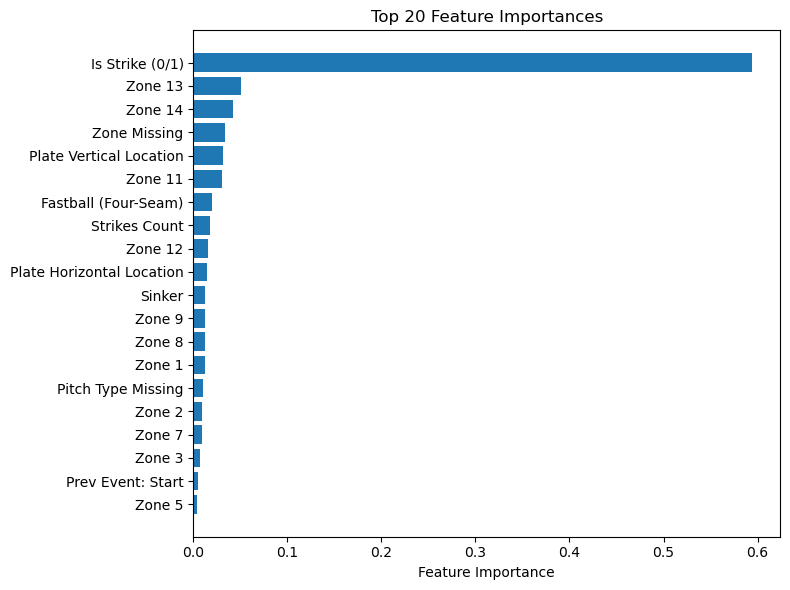

In [12]:
# Feature Importance
# Friendly labels for features
LABEL_MAP = {
    'release_speed':    'Pitch Release Speed (mph)',
    'plate_x':          'Plate Horizontal Location',
    'plate_z':          'Plate Vertical Location',
    'release_pos_x':    'Release Point X',
    'release_pos_z':    'Release Point Z',
    'release_extension':'Pitcher Release Extension (ft)',
    'pfx_x':            'Horizontal Movement (in)',
    'pfx_z':            'Vertical Movement (in)',
    'balls':            'Balls Count',
    'strikes':          'Strikes Count',
    'pre_run_exp':      'Pre-run Expectation',
    'is_strike':        'Is Strike (0/1)',
    'strike_streak':    'Consecutive Strikes',
    'outs_when_up':     'Outs When Up',
    'runners_on':       'Runners On Base',
    'score_diff':       'Score Differential',
    'inning':           'Inning Number',
    'stand_L':          'Batter is Left-Handed',
    'stand_R':          'Batter is Right-Handed',
    'p_throws_L':       'Pitcher is Left-Handed',
    'p_throws_R':       'Pitcher is Right-Handed',
    'pitch_type_FF':    'Fastball (Four-Seam)',
    'pitch_type_SL':    'Slider',
    'pitch_type_CH':    'Changeup',
    'pitch_type_CU':    'Curveball',
    'pitch_type_SI':    'Sinker',
    'pitch_type_nan':   'Pitch Type Missing',
    'zone_1.0':         'Zone 1',
    'zone_2.0':         'Zone 2',
    'zone_3.0':         'Zone 3',
    'zone_4.0':         'Zone 4',
    'zone_5.0':         'Zone 5',
    'zone_6.0':         'Zone 6',
    'zone_7.0':         'Zone 7',
    'zone_8.0':         'Zone 8',
    'zone_9.0':         'Zone 9',
    'zone_10.0':        'Zone 10',
    'zone_11.0':        'Zone 11',
    'zone_12.0':        'Zone 12',
    'zone_13.0':        'Zone 13',
    'zone_14.0':        'Zone 14',
    'zone_nan':         'Zone Missing',
    'prev_event_start':          'Prev Event: Start',
    'prev_event_ball':           'Prev Event: Ball',
    'prev_event_called_strike':  'Prev Event: Called Strike',
    'prev_event_swinging_strike':'Prev Event: Swinging Strike',
    'prev_event_foul':           'Prev Event: Foul',
}

def plot_feature_importance(model, preprocessor, top_n=20):
    """
    Plot top_n feature importances using friendly labels.
    """
    # 1. Get raw feature names
    raw_names = preproc.get_feature_names_out()
    # 2. Strip prefixes "num__"/"cat__"
    clean_names = [n.split("__",1)[1] for n in raw_names]
    # 3. Map to friendly labels
    friendly = [LABEL_MAP.get(n, n) for n in clean_names]
    # 4. Get importances and pick top_n
    imps = model.feature_importances_
    idx = np.argsort(imps)[-top_n:]
    names = [friendly[i] for i in idx]
    scores = imps[idx]

    # 5. Plot horizontal bar chart
    plt.figure(figsize=(8,6))
    plt.barh(names, scores)
    plt.xlabel("Feature Importance")
    plt.title(f"Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, preprocessor, top_n=20)

## 6. Top/Bottom 10 Leaderboard

In [14]:
# Top/Bottom 10 Leaderboard
from pybaseball import playerid_reverse_lookup

df_feat = pd.read_csv("../data/processed/statcast_features.csv")

# load model & preprocessor
model = xgb.XGBRegressor()
model.load_model("../models/xgb_model.json")
preproc = joblib.load("../models/preprocessor.joblib")

# reverse-lookup batter names
ids = df_feat['batter'].unique().tolist()
lookup = playerid_reverse_lookup(ids, key_type='mlbam')
lookup['batter_name'] = lookup['name_first'] + ' ' + lookup['name_last']
# merge names into df
df_feat = df_feat.merge(
    lookup[['key_mlbam','batter_name']],
    left_on='batter', right_on='key_mlbam', how='left'
)

#  - predict on all pitches
X_all = df_feat[numeric_features + categorical_features]
df_feat['pred'] = model.predict(preproc.transform(X_all)) * 100

#  - filter batters with at least 1000 pitches
counts = df_feat['batter'].value_counts()
valid = counts[counts>=1000].index
mean_preds = df_feat[df_feat['batter'].isin(valid)].groupby('batter')['pred'].mean().round(2)

#  - top/bottom 10 IDs
top_ids    = mean_preds.nlargest(10).index
bottom_ids = mean_preds.nsmallest(10).index

#  - map to names & build DataFrames
name_map = df_feat.drop_duplicates('batter').set_index('batter')['batter_name']
top10 = pd.DataFrame({
    'batter_name': name_map[top_ids].values,
    'mean_pred':    mean_preds[top_ids].values
})
bottom10 = pd.DataFrame({
    'batter_name': name_map[bottom_ids].values,
    'mean_pred':    mean_preds[bottom_ids].values
})

# display
print("🏆 Top 10 Batters:")
display(top10)
print("📉 Bottom 10 Batters:")
display(bottom10)


🏆 Top 10 Batters:


,batter_name,mean_pred
0,luis arráez,3.89
1,jeff mcneil,3.49
2,alec burleson,3.38
3,josé ramírez,3.33
4,jackson merrill,3.32
5,freddie freeman,3.24
6,andrew benintendi,3.23
7,tony kemp,3.20
8,mauricio dubón,3.17
9,will brennan,3.16


📉 Bottom 10 Batters:


,batter_name,mean_pred
0,josé siri,0.05
1,nick pratto,0.14
2,avisaíl garcía,0.16
3,franmil reyes,0.30
4,christian bethancourt,0.32
5,elehuris montero,0.43
6,javier báez,0.46
7,mickey moniak,0.48
8,joey bart,0.63
9,jake burger,0.65


## 7. Single‐Player Analysis

Enter a player name, then compute & plot his decision‐quality difference vs league.

Analyzing: mike trout  (ID 545361)
Decision quality comparison (per 100 pitches):


,balls,strikes,league,player,diff
0,0,0,1.471348,1.590197,0.12
1,0,1,1.753538,2.065409,0.31
2,0,2,3.421173,4.105787,0.68
3,1,0,1.344982,1.464975,0.12
4,1,1,1.432559,1.183436,-0.25
5,1,2,3.100092,3.448304,0.35
6,2,0,1.639275,1.695169,0.06
7,2,1,1.553180,2.098986,0.55
8,2,2,2.951755,2.121147,-0.83
9,3,0,0.282800,2.139549,1.86


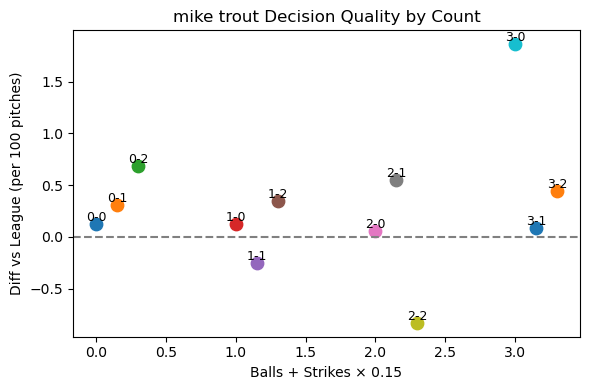

In [16]:
# Single-Player Analysis

# Robust name lookup
player_input = "Mike Trout"  # Enter the player here

# Ensure we have batter_name in df_feat
names_lower = df_feat['batter_name'].str.lower()

# 1) Exact match
mask = names_lower == player_input.lower()
# 2) If none, try substring match
if not mask.any():
    mask = names_lower.str.contains(player_input.lower(), na=False)
# 3) If still none, list some available names and abort
if not mask.any():
    print(f"No match for '{player_input}'. Available examples:")
    display(pd.Series(df_feat['batter_name'].unique()).sort_values().head(20))
    raise SystemExit

# 4) If multiple, show and pick first
matched = df_feat.loc[mask, 'batter_name'].unique()
if len(matched) > 1:
    print("Multiple matches found:", matched)
    player_name = matched[0]
    print(f"Selecting first: {player_name}")
else:
    player_name = matched[0]

# Retrieve the corresponding batter ID
batter_id = df_feat.loc[df_feat['batter_name'] == player_name, 'batter'].iloc[0]
print(f"Analyzing: {player_name}  (ID {batter_id})")


# Compute league vs player by count
#  – (re)predict on all pitches, scaled per 100
model   = xgb.XGBRegressor()
model.load_model("../models/xgb_model.json")
preproc = joblib.load("../models/preprocessor.joblib")

df_feat['pred'] = model.predict(
    preproc.transform(df_feat[numeric_features + categorical_features])
) * 100

# League average per (balls, strikes) count
league = df_feat.groupby(['balls', 'strikes'])['pred'].mean()

# Player average per count
player = (
    df_feat[df_feat['batter'] == batter_id]
    .groupby(['balls', 'strikes'])['pred']
    .mean()
)

# Combine into comparison DataFrame
comp_df = pd.DataFrame({'league': league, 'player': player}).dropna()
comp_df['diff'] = (comp_df['player'] - comp_df['league']).round(2)
comp_df = comp_df.reset_index()

print("Decision quality comparison (per 100 pitches):")
display(comp_df)


# Plot diff vs league by count
plt.figure(figsize=(6,4))
for _, row in comp_df.iterrows():
    b, s = int(row['balls']), int(row['strikes'])
    x = b + s * 0.15      # offset strikes slightly for readability
    y = row['diff']
    plt.scatter(x, y, s=80)
    plt.text(x, y, f"{b}-{s}", ha='center', va='bottom', fontsize=9)

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Balls + Strikes × 0.15')
plt.ylabel('Diff vs League (per 100 pitches)')
plt.title(f'{player_name} Decision Quality by Count')
plt.tight_layout()
plt.show()


## 8. Conclusion & Future Work

**Conclusions**  
- The XGBoost regression model effectively captures swing decision quality across counts using 2022–2024 Statcast data.  
- Key predictive features include `is_strike`, specific `zone` indicators, and `pre_run_exp` (run expectancy)—reflecting both pitch characteristics and game context.  
- The leaderboard highlights clear performance separation: top hitters consistently exceed league average decision values, while bottom hitters fall below.  
- Single-player analysis (e.g. Mike Trout) shows count-specific strengths and weaknesses, providing actionable insights for coaching and player development.  
- **We can now visualize each player’s swing decision quality at specific balls–strikes counts**, enabling targeted improvements.

**Future Work**   
1. **Deploy as an interactive web app**  
   - Build a Streamlit or Flask application to allow users (coaches, analysts) to input a player name or game situation and visualize decision-quality metrics in real-time.  
2. **Implement continuous training pipeline**  
   - Automate data ingestion from Statcast, feature engineering, model retraining, and leaderboard updates via CI/CD (GitHub Actions or Airflow).  
3. **Extend to situational analysis**  
   - Analyze decision quality in high-leverage situations (late innings, close score) and other game contexts (e.g., runners in scoring position, playoff games) to uncover deeper performance patterns.  
